# NYC EMS
A time series analysis of medical emergency Call Volumes and Response Times in the five boroughs.

We were curious about **Time Series** analysis and modeling: Using temporal lags of a dependent variable as predictors of that same variable, in tandem with **other exogenous variables**, to infer values into the future, and validating those predictions.

Some readily available data pertaining to ambulance call volumes and response durations, we thought, might be a good candidate for this sort of investigation and experimentation: The real-world applications are pressing and easily explained. It'd be good to be able to approximate how many ambulances ought to be on the road at any given time, and it'd be nice to be able to guess how long it will take for the ambulance to reach an ailing denizen.

In [1]:
import datetime, itertools, warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Grouper
from matplotlib.pylab import rcParams

from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In separate notebooks, we did some pre-processing with our EMS, weather, and holiday data. Below, we further prepare the data for time series modeling.

Our principal data came from NYC's Open Data portal, at https://data.cityofnewyork.us/Public-Safety/EMS-Incident-Dispatch-Data/76xm-jjuj.

In [2]:
coerced_data = pd.read_csv('../data/ems_datetime_fixed.csv')

In [3]:
# Drop unnecessary columns and ensure time is the index
coerced_data = coerced_data.drop(['Unnamed: 0', 'INCIDENT_DATETIME'], axis=1).set_index('proper_time')
coerced_data.index = pd.to_datetime(coerced_data.index)

One of our goals is to measure the frequency of calls over different time periods, so we need a way to tally calls when we call the "resample" method. Here we'll add a column where we assign a simple value of 1 to every call, and soon we'll use it to tally.

In [4]:
coerced_data['count'] = 1

In [5]:
coerced_data.head()

,INITIAL_CALL_TYPE,INITIAL_SEVERITY_LEVEL_CODE,FINAL_CALL_TYPE,FINAL_SEVERITY_LEVEL_CODE,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,ZIPCODE,POLICEPRECINCT,STANDBY_INDICATOR,Change_In_Severity,count
proper_time,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,RESPIR,4,RESPIR,4,Y,101,Y,797.0,N,82.0,BRONX,10472.0,43.0,N,0,1
2013-01-01 00:00:19,CARD,3,CARD,3,Y,59,Y,851.0,N,93.0,BRONX,10454.0,40.0,N,0,1
2013-01-01 00:01:04,ARREST,1,ARREST,1,Y,29,Y,429.0,N,83.0,QUEENS,11418.0,102.0,N,0,1
2013-01-01 00:01:16,SICK,6,SICK,6,Y,56,Y,828.0,N,82.0,BRONX,10453.0,46.0,N,0,1
2013-01-01 00:01:26,INJURY,5,INJURY,5,Y,32,Y,856.0,N,82.0,BRONX,10457.0,48.0,N,0,1


Now that the EMS data looks good, let's add in some weather data. 

In [6]:
weather_data = pd.read_csv('../data/weather_data.csv')

In [7]:
weather_data.set_index('Date', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

In [8]:
weather_data.head()

,Max Temp,Min Temp,Avg Temp,Precipitation Water Equiv,Snowfall,Snow/Ice Depth
Date,,,,,,
2013-01-01,40,26.0,33.0,0.0,0.0,0.0
2013-01-02,33,22.0,27.5,0.0,0.0,0.0
2013-01-03,32,24.0,28.0,0.0,0.0,0.0
2013-01-04,37,30.0,33.5,0.0,0.0,0.0
2013-01-05,42,32.0,37.0,0.0,0.0,0.0


And let's add in some holiday data. 

In [9]:
holiday_data = pd.read_csv('../data/holiday_data.csv')

In [10]:
holiday_data.set_index('Date', inplace=True)
holiday_data.index = pd.to_datetime(holiday_data.index)

In [11]:
holiday_data.head()

,Holiday
Date,
2013-01-01,True
2013-01-02,False
2013-01-03,False
2013-01-04,False
2013-01-05,False


We ultimately decided to resample down to the __week__ level, because we tried __daily__ granularity and it was too...granular. E.g. just because there were a lot of 911 calls 365 days ago does not mean there will be a lot today—unless, perhaps, it's Halloween or something, but we didn't find that to be the case. So we went with __Weeks__.

(What this meant for the holiday data is that we ended up with a binary variable for whether or not there was a holiday that week.)

For EMS data, we want the average response time per week, and the total number of calls per week. For the weather data, we want the average weekly temperature, as well as the total rainfall and snowfall per week. Lastly, for the holiday data, we want the total number of holidays per week. 

In [12]:
weekly_call_volume = coerced_data['count'].resample('W').sum()
weekly_average_response_time = coerced_data['INCIDENT_RESPONSE_SECONDS_QY'].resample('W').mean()

#modify our avearge response time data to measure time in minutes instead of seconds
weekly_average_response_time = weekly_average_response_time / 60

In [13]:
weekly_average_temperature_data = pd.DataFrame(weather_data['Avg Temp'].resample('W').mean())
weekly_sum_precipitation = pd.DataFrame(weather_data['Precipitation Water Equiv'].resample('W').sum())
weekly_sum_snowfall = pd.DataFrame(weather_data['Snowfall'].resample('W').sum())

In [14]:
weekly_sum_holidays = holiday_data.resample('W').sum()

Let's create a DataFrame to merge average response time data with holiday and weather data.

In [15]:
weekly_average_response_time_df = pd.DataFrame(data=weekly_average_response_time, 
                                               index=weekly_average_response_time.index)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, 
                                           weekly_average_temperature_data, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, 
                                           weekly_sum_precipitation, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, 
                                           weekly_sum_snowfall, left_index=True, right_index=True)

weekly_average_response_time_df = pd.merge(weekly_average_response_time_df, 
                                           weekly_sum_holidays, left_index=True, right_index=True)

# Renaming the columns so they are easier to understand and reference
weekly_average_response_time_df.columns = ['avg_response_time_min', 'avg_temp', 'total_precip', 
                                           'total_snowfall', 'total_holidays']

In [16]:
weekly_average_response_time_df.head()

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,11.203026,33.166667,0.0001,0.001,1.0
2013-01-13,11.848662,43.214286,0.5700,0.000,0.0
2013-01-20,9.846154,38.428571,0.9000,0.001,0.0
2013-01-27,8.906825,21.071429,0.0701,1.501,1.0
2013-02-03,9.237061,35.428571,1.2600,0.401,0.0


Create a DataFrame to merge average call volume data with holiday and weather data.

In [17]:
weekly_call_volume_df = pd.DataFrame(data=weekly_call_volume, index=weekly_call_volume.index)

weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_average_temperature_data, 
                                 left_index=True, right_index=True)

weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_precipitation, 
                                 left_index=True, right_index=True)

weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_snowfall, 
                                 left_index=True, right_index=True)

weekly_call_volume_df = pd.merge(weekly_call_volume_df, weekly_sum_holidays, 
                                 left_index=True, right_index=True)

# Rename the columns so they are easier to understand and reference
weekly_call_volume_df.columns = ['sum of weekly calls', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

In [18]:
weekly_call_volume_df.head()

,sum of weekly calls,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2013-01-06,23449,33.166667,0.0001,0.001,1.0
2013-01-13,27193,43.214286,0.5700,0.000,0.0
2013-01-20,25044,38.428571,0.9000,0.001,0.0
2013-01-27,23313,21.071429,0.0701,1.501,1.0
2013-02-03,24656,35.428571,1.2600,0.401,0.0


## EDA and Stationarity Check 

We wanted to see if there were any noticeable trends, so we explored the data through visualizations. Additionally, stationarity is a key assumption for time series models, so we used the Dickey-Fuller test statistic to test for stationarity. 

### Dickey-Fuller Tests:

In [19]:
# Create function to perform Dickey-Fuller test and print key statistics
def dickey_fuller(ser):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ser.values)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return None

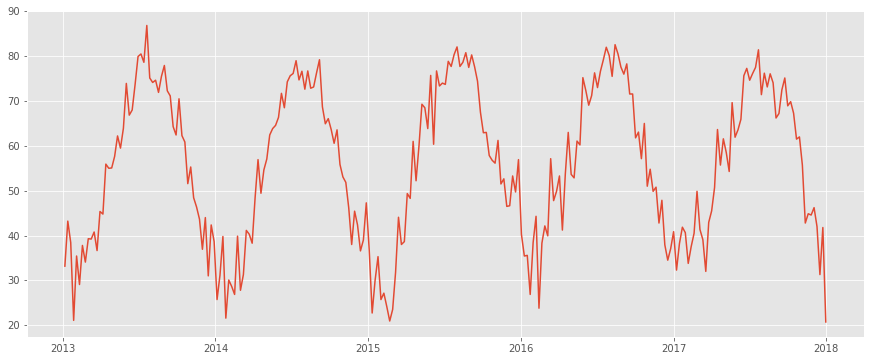

Results of Dickey-Fuller Test:
Test Statistic                -7.373287e+00
p-value                        8.855958e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [23]:
# Viz and Dickey-Fuller for weekly average temperature 
plt.figure(figsize=(15,6))
plt.plot(weekly_average_response_time_df['avg_temp'])
plt.show()
dickey_fuller(weekly_average_response_time_df['avg_temp'])

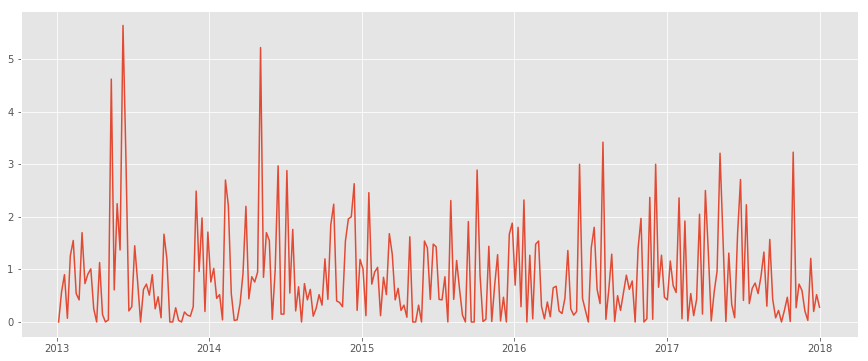

Results of Dickey-Fuller Test:
Test Statistic                -1.654803e+01
p-value                        1.956570e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.600000e+02
Critical Value (1%)           -3.455754e+00
Critical Value (5%)           -2.872721e+00
Critical Value (10%)          -2.572728e+00
dtype: float64


In [24]:
# Viz and Dickey-Fuller for total weekly precipitation
plt.figure(figsize=(15,6))
plt.plot(weekly_average_response_time_df['total_precip'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_precip'])

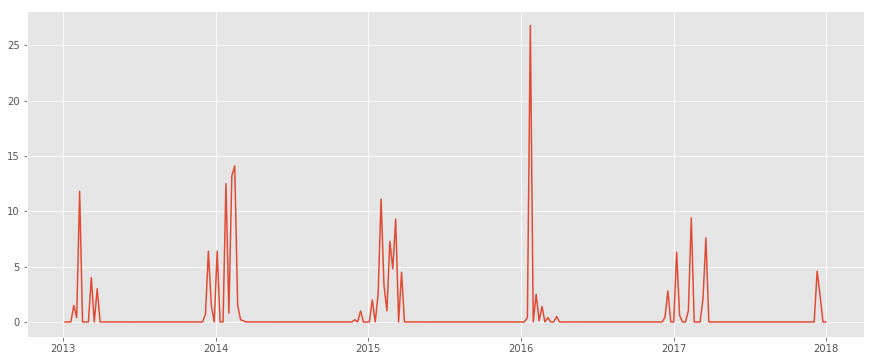

Results of Dickey-Fuller Test:
Test Statistic                -6.801037e+00
p-value                        2.236803e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


In [25]:
# Viz and Dickey-Fuller for total weekly snowfall  
plt.figure(figsize=(15,6))
plt.plot(weekly_average_response_time_df['total_snowfall'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_snowfall'])

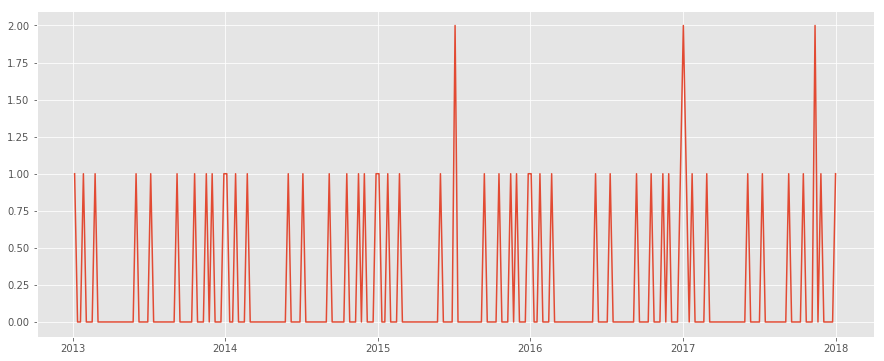

Results of Dickey-Fuller Test:
Test Statistic                  -4.678656
p-value                          0.000092
#Lags Used                      13.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [26]:
# Viz and Dickey-Fuller for total number of holidays in a week 
plt.figure(figsize=(15,6))
plt.plot(weekly_average_response_time_df['total_holidays'])
plt.show()
dickey_fuller(weekly_average_response_time_df['total_holidays'])

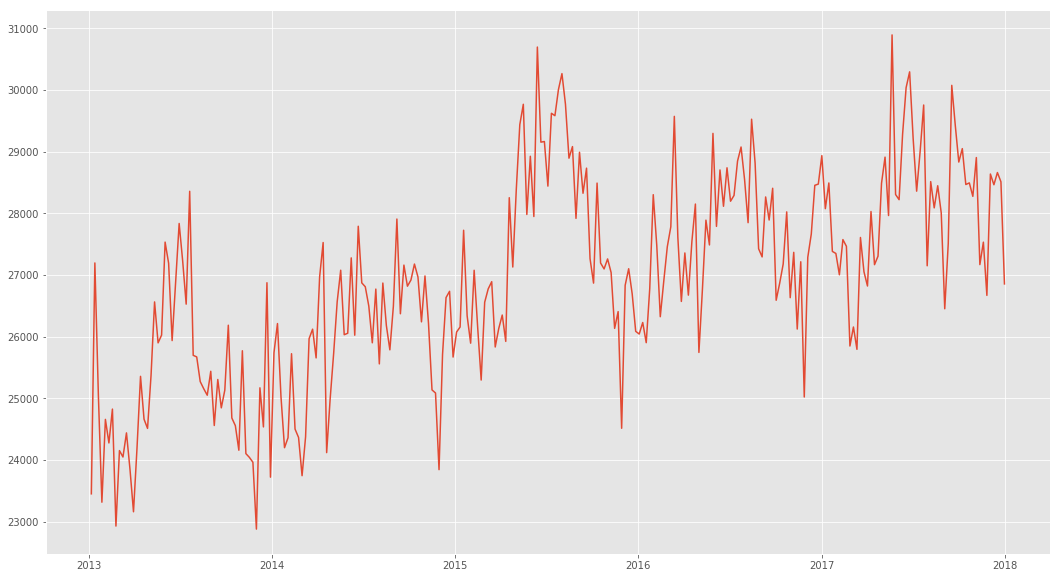

Results of Dickey-Fuller Test:
Test Statistic                  -2.774700
p-value                          0.061980
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


In [31]:
# Viz and Dickey-Fuller for total number of calls in a week 
plt.figure(figsize=(18,10))
plt.plot(weekly_call_volume)
plt.show()
dickey_fuller(weekly_call_volume)

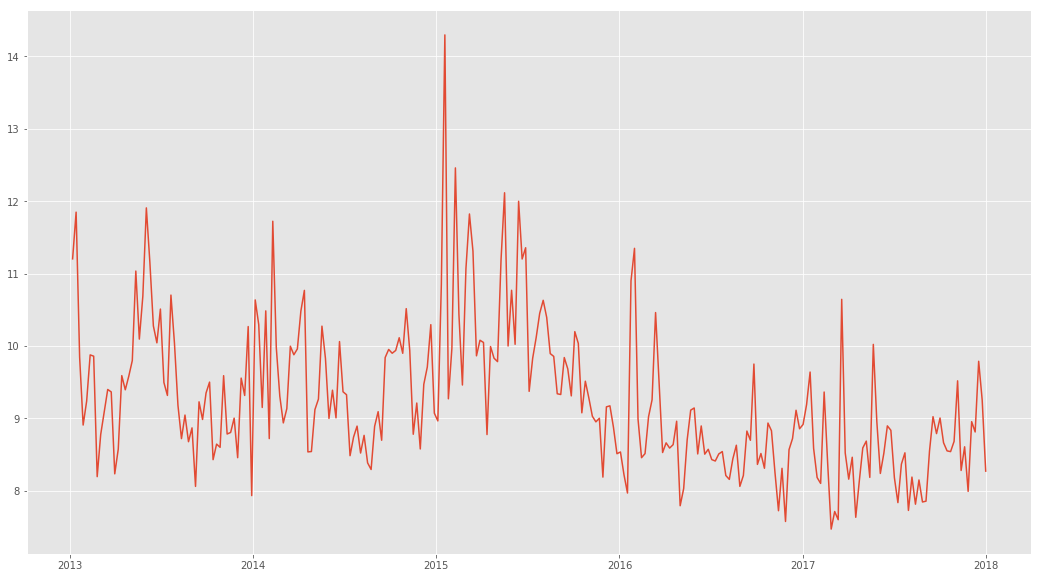

Results of Dickey-Fuller Test:
Test Statistic                  -3.759599
p-value                          0.003349
#Lags Used                       3.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


In [30]:
# Viz and Dickey-Fuller for weekly average response time 
plt.figure(figsize=(18,10))
plt.plot(weekly_average_response_time)
plt.show()
dickey_fuller(weekly_average_response_time)

At first glance, we get a decent P-vals for our stationarity checks on the total number of calls in a week and the weekly average response time, but we know we can do better. There is some obvious seasonality in both dependent variables, and a clear upward trend in call volumes over the years.

### Seasonality and Trends

EMS Response time:

<Figure size 432x288 with 0 Axes>

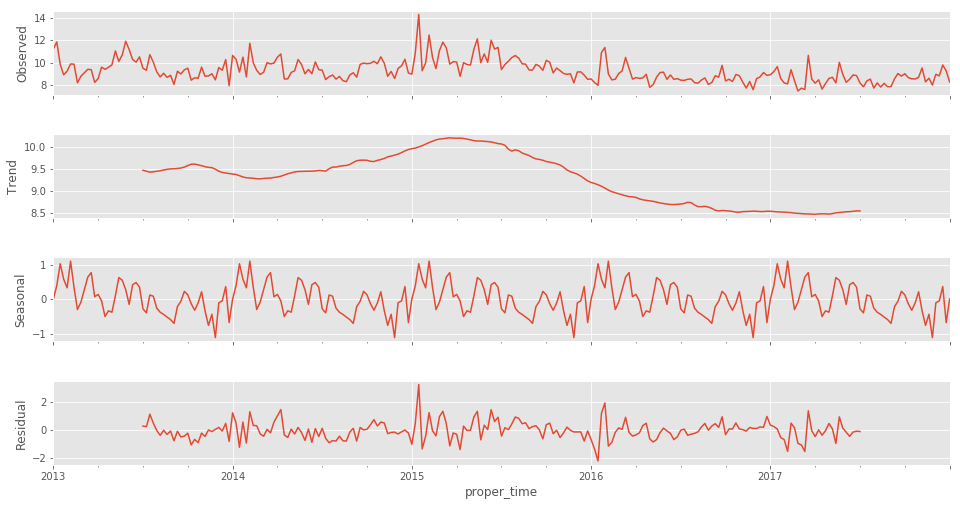

In [34]:
# Seasonal decomposition for weekly average response time 
decomposition = seasonal_decompose(weekly_average_response_time, freq=52)  
fig = plt.figure()
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

Call Volume:

<Figure size 432x288 with 0 Axes>

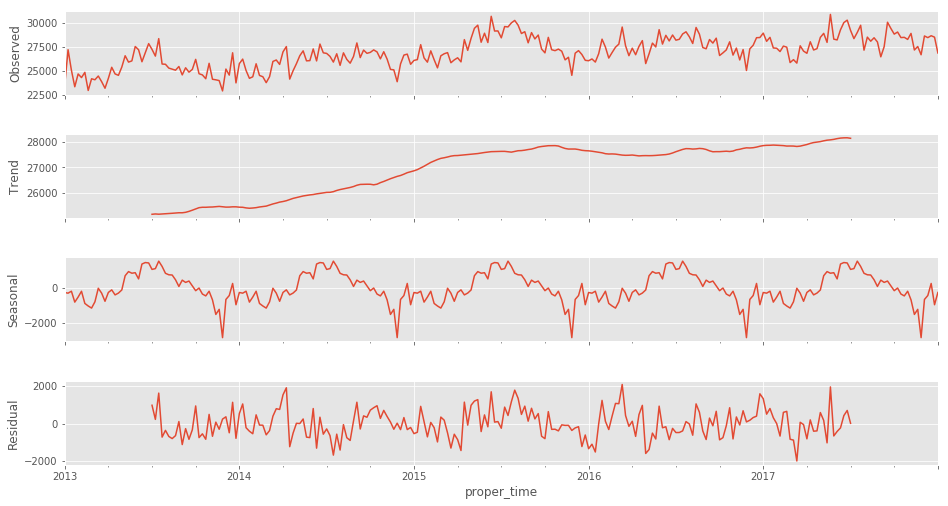

In [33]:
# Seasonal decomposition for total number of calls in a week 
decomposition = seasonal_decompose(weekly_call_volume, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Seasonal First-Differencing:

EMS Response Time:

In [35]:
# For average response time, found seasonal first difference to produce best results
response_time_first_diff = weekly_average_response_time - weekly_average_response_time.shift(1)
response_time_seasonal_first_difference = (response_time_first_diff - response_time_first_diff.shift(52)).dropna()
dickey_fuller(response_time_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -1.025001e+01
p-value                        4.511493e-18
#Lags Used                     5.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (1%)           -3.463144e+00
Critical Value (5%)           -2.875957e+00
Critical Value (10%)          -2.574455e+00
dtype: float64


EMS Call Volume:

In [36]:
# For call volume, found seasonal first difference to produce best results
call_volume_first_diff = weekly_call_volume - weekly_call_volume.shift(1)
call_volume_seasonal_first_difference = (call_volume_first_diff - call_volume_first_diff.shift(52)).dropna()
dickey_fuller(call_volume_seasonal_first_difference)

Results of Dickey-Fuller Test:
Test Statistic                -6.390973e+00
p-value                        2.106404e-08
#Lags Used                     1.100000e+01
Number of Observations Used    1.960000e+02
Critical Value (1%)           -3.464161e+00
Critical Value (5%)           -2.876402e+00
Critical Value (10%)          -2.574692e+00
dtype: float64


### Autocorrelation and Partial Autocorrelation:

EMS Response time:

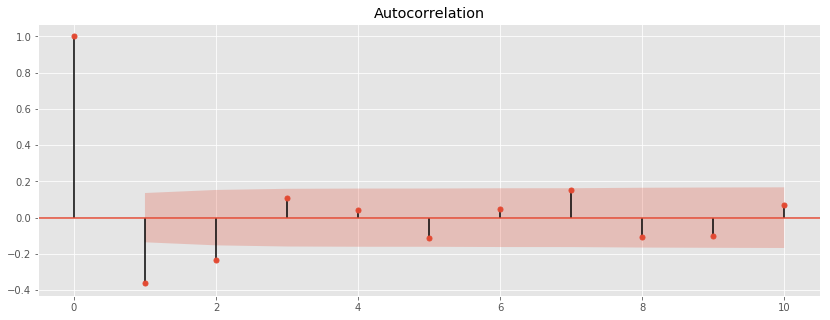

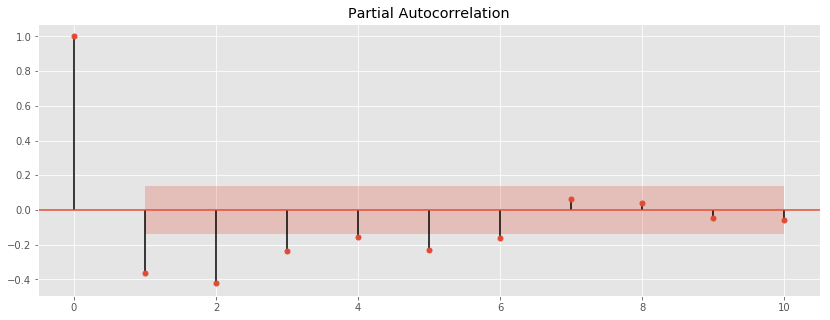

In [37]:
# ACF and PCF for average response time 
rcParams['figure.figsize'] = 14, 5
plot_acf(response_time_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(response_time_seasonal_first_difference, lags = 10);

Call Volume:

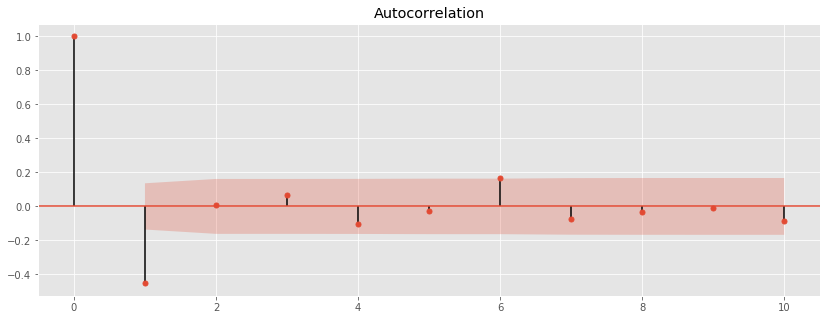

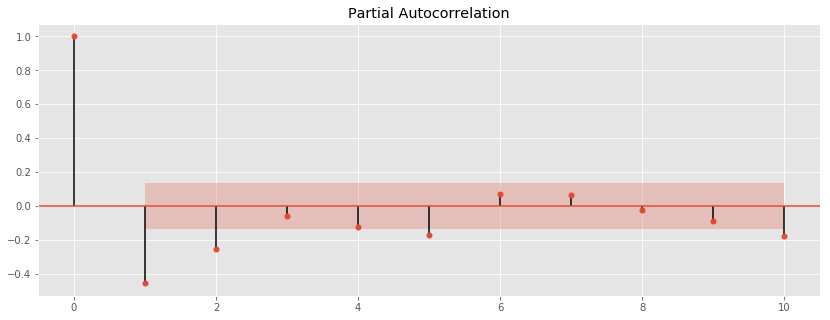

In [38]:
# ACF and PCF for call volume
rcParams['figure.figsize'] = 14, 5
plot_acf(call_volume_seasonal_first_difference, lags = 10);

rcParams['figure.figsize'] = 14, 5
plot_pacf(call_volume_seasonal_first_difference, lags = 10);

# Forecasting

We'll start with:

## Average EMS Vehicle Response Time

Here, we suspend our manual investigation and leave it to the machine to "grid search" for ideal auto-regression and seasonal terms.

In [39]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [40]:
def arima_gs(ts):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}52 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

    # Find the parameters with minimal AIC value.

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    print(ans_df)
    print(ans_df.loc[ans_df['aic'].idxmin()])

In [41]:
# arima_gs(weekly_average_response_time)

We decided to split our data into training and test sets with an 80-20 split, manually chopping off the end of the time series.

In [42]:
endogenous_train = weekly_average_response_time[:-52]
exogenous_train = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[:-52]
endogenous_test = weekly_average_response_time[-52:]
exogenous_test = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[-52:]

Now we fit the SARIMAX model on the training data with the optimal parameters we found above.

Note that we're including our exogenous variables like holidays and weather stuff.

In [43]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp           0.0112         -0       -inf      0.000       0.011       0.011
total_precip       0.1621         -0       -inf      0.000       0.162       0.162
total_snowfall     0.0688    9.2e-37   7.48e+34      0.000       0.069       0.069
total_holidays     0.1355   1.09e-36   1.25e+35      0.000       0.135       0.135
ar.L1              0.8762   5.15e-37    1.7e+36      0.000       0.876       0.876
ma.L1             -0.4783   6.63e-36  -7.21e+34      0.000      -0.478      -0.478
ma.S.L52        2.131e+14   1.66e-33   1.28e+47      0.000    2.13e+14    2.13e+14
sigma2          3.217e-13   1.87e-10      0.002      0.999   -3.66e-10    3.67e-10


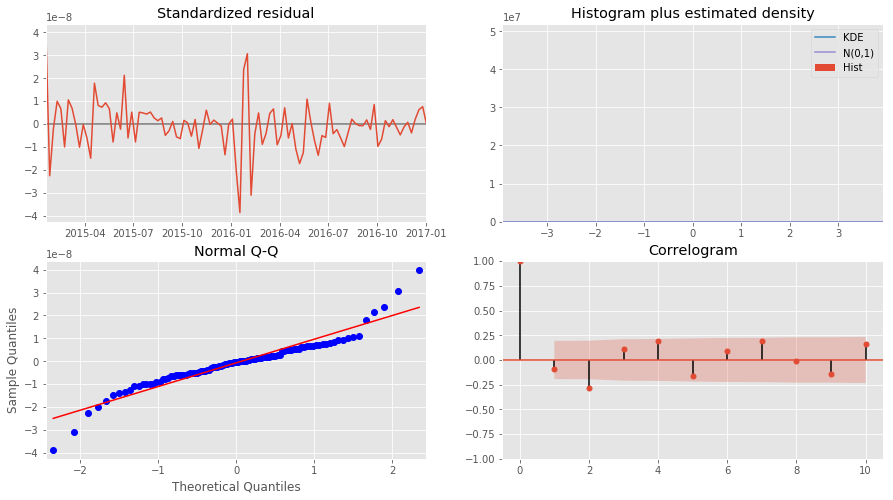

In [44]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

Cool! Now let's generate predictions.

In [45]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

Let's see what our predictions look like against actual values. 

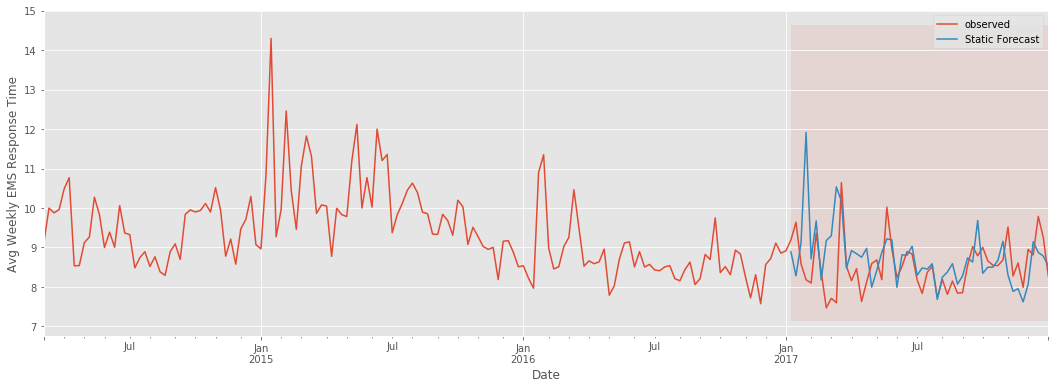

In [48]:
# Plot the static forecast with confidence intervals.

ax = weekly_average_response_time[-200:].plot(label='observed', figsize=(18, 6))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-52:-50].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly EMS Response Time')

plt.legend()
plt.show()

To baseline our SARIMAX model, we devise here a dummy forecaster that just always guesses the global average response time.

In [49]:
response_time_mean = np.zeros((len(weekly_average_response_time),1))
response_time_mean.fill(np.mean(weekly_average_response_time[:-52]))
response_time_mean = pd.DataFrame(response_time_mean, 
                                      index=weekly_average_response_time.index)

baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 1.1930240270839332
The RMSE when guessing the mean is 1.0922563925580537


So, without fancy machine learning methods, we're not usually wrong by much more or less than 1.09 minutes. That's, wow, actually pretty decent...

In [52]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

print(f'''Our model's error is' {np.round((((baseline_rmse - rmse) / baseline_rmse) * 100), 
                                    decimals=2)}% less than when we just always guess the mean response time!''')

The MSE for this model is 0.8180191200198088
The RMSE for this model is 0.9044440944689776
Our model's error is' 17.19% less than when we just always guess the mean response time!


Phew, we squeezed an extra ~20% performance out of the data with a little time series magic.

## Forecasting: Call Volume

The other thing we wanted to predict was how many calls would be placed during any given week in the future:

In [53]:
endogenous_train = weekly_call_volume[:-52]
exogenous_train = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[:-52]
endogenous_test = weekly_call_volume[-52:]
exogenous_test = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[-52:]

Here we run the same "grid search" type function to find our ideal time series terms:

In [54]:
# arima_gs(weekly_call_volume)

Our grid search actually returned the same parameters for call volume that it did for response times, unsurprisingly. These are pretty much colinear endogenous variables: We can expect for ambulances to take longer to reach people when there are lots of people calling for ambulances.

In [55]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                exog = exogenous_train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          86.6069         -0       -inf      0.000      86.607      86.607
total_precip     -29.8947         -0        inf      0.000     -29.895     -29.895
total_snowfall    37.3603   1.27e-33   2.94e+34      0.000      37.360      37.360
total_holidays   230.0114   1.93e-33   1.19e+35      0.000     230.011     230.011
ar.L1              0.9385   4.48e-31    2.1e+30      0.000       0.938       0.938
ma.L1             -0.4361   6.41e-31   -6.8e+29      0.000      -0.436      -0.436
ma.S.L52       -5.036e+14   7.04e-34  -7.15e+47      0.000   -5.04e+14   -5.04e+14
sigma2          6.536e-14   1.87e-10      0.000      1.000   -3.66e-10    3.66e-10


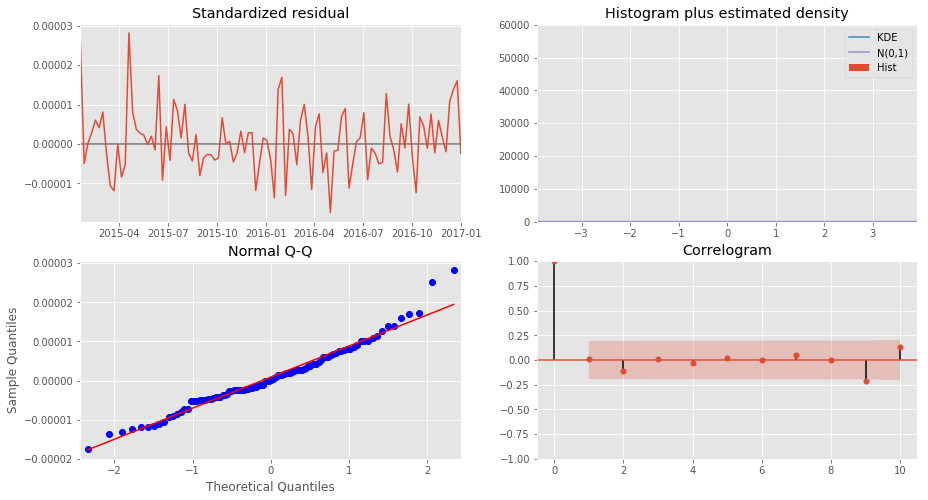

In [56]:
output.plot_diagnostics(figsize=(15, 8))
plt.show()

In [57]:
prediction = output.get_prediction(start = endogenous_test.index[0],
                                    end = endogenous_test.index[-1],
                                    exog = exogenous_test,
                                    dynamic = False)

pred_conf = prediction.conf_int()

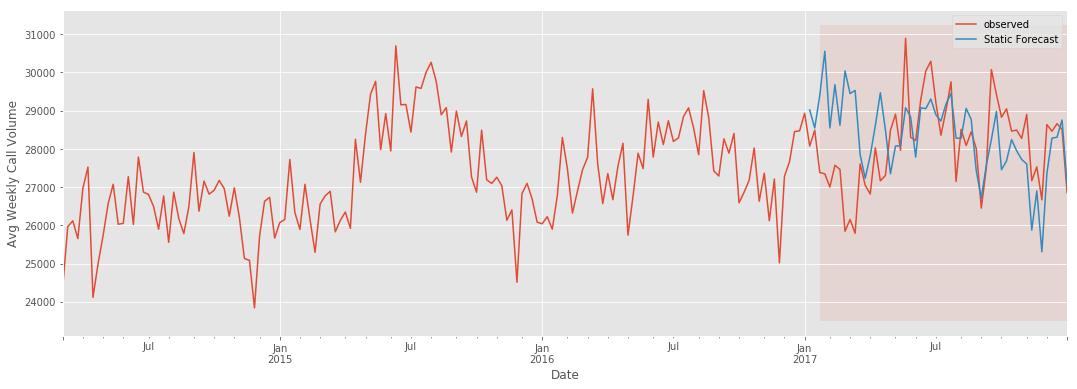

In [58]:
# Plot the static forecast with confidence intervals.

ax = weekly_call_volume[-200:].plot(label='observed', figsize=(18, 6))
prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

# ax.fill_between(pred_conf.index,
#                 pred_conf.iloc[:, 0],
#                 pred_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-50:-49].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Weekly Call Volume')

plt.legend()
plt.show()

Already we start to see that our model may be overfitting a bit, except for that first part

In [59]:
call_vol_mean = np.zeros((len(weekly_call_volume),1))
call_vol_mean.fill(np.mean(weekly_call_volume[:-52]))
call_vol_mean = pd.DataFrame(call_vol_mean, 
                                      index=weekly_call_volume.index)

In [61]:
baseline_mse = np.mean((call_vol_mean[-52:][0] - endogenous_test)**2)
baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 3483004.8492078898
The RMSE when guessing the mean is 1866.2810209633194


In plain English, it seems that if we just guessed the mean call-volume every week, we'd be off by roughly 1,800 calls per week, which is not so bad considering the tremendous volume of EMS calls placed weekly.

In [67]:
print(f'There are usually around {np.round((26908.908046),2)} calls per week.')

There are usually around 26908.91 calls per week.


In [62]:
mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {}'.format(rmse))

The MSE for this model is 1928712.291820028
The RMSE for this model is 1388.78086529878


In [63]:
print(f'''Our model does {np.round((((baseline_rmse - rmse) / baseline_rmse) * 100), 
                                    decimals=2)}% better than guessing the mean call volume!''')

Our model does 25.59% better than guessing the mean call volume!


## Vs. Facebook Prophet

Now that we've gone and attempted to build our own custom SARIMAX models, we wanted to pit them against the readily available and frighteningly easy-to-use forecasting tool made by Facebook called "prophet". It's so simple to use, how good can it really be? Turns out it gave our models a very good run for their money...

On **call volume**:

Just re-prepping data:

In [70]:
endogenous_train = weekly_call_volume[:-52]
exogenous_train = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[:-52]
endogenous_test = weekly_call_volume[-52:]
exogenous_test = weekly_call_volume_df.drop(['sum of weekly calls'], axis=1)[-52:]

Creating a "prophet" class object:

In [71]:
df = pd.DataFrame(endogenous_train) # Formatting a DF how Prophet likes it
df.columns = ['y']
df['ds'] = df.index
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

Forecasting:

In [72]:
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)

In [73]:
forecast.index = pd.date_range(start=df.index[0], periods=len(forecast), freq='W')

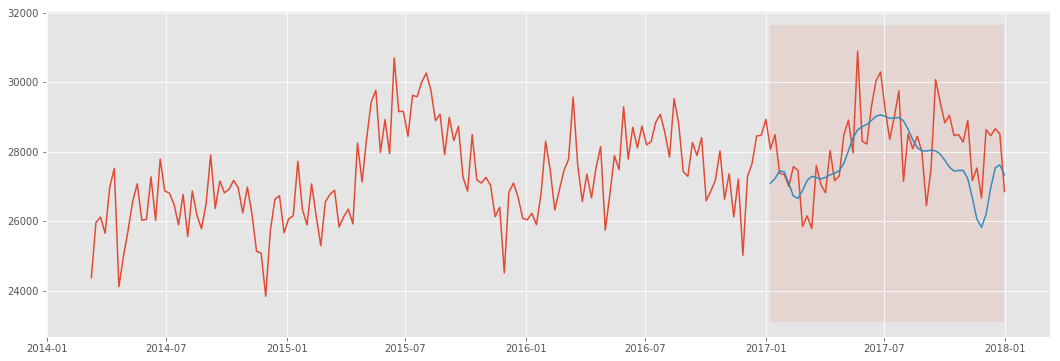

In [75]:
plt.figure(figsize=(18,6))
plt.plot(weekly_call_volume[-200:])

plt.fill_betweenx(ax.get_ylim(), 
                 weekly_average_response_time[-52:-50].index[0], 
                 '2017-12-31', 
                 alpha=.1, zorder=-1)

plt.plot(forecast['yhat'][-52:])
plt.show()

We can see right away that Prophet does a great job, nicely relaxing and not overfitting to the jaggy dataset too much. We fear that it will outperform the one we built ourselves.

Error Metrics:

In [76]:
call_vol_mean = np.zeros((len(weekly_call_volume),1))
call_vol_mean.fill(np.mean(weekly_call_volume[:-52]))

call_vol_mean = pd.DataFrame(call_vol_mean, 
                                      index=weekly_call_volume.index)

baseline_mse = np.mean((call_vol_mean[-52:][0] - endogenous_test)**2)

baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 3483004.8492078898
The RMSE when guessing the mean is 1866.2810209633194


In [78]:
mse = ((forecast['yhat'][-52:] - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {} \n'.format(rmse))

print(f'''This model does {np.round((((baseline_rmse - rmse) / baseline_rmse) * 100), 
                                    decimals=2)}% better than guessing the weekly call volume!''')

The MSE for this model is 1059915.3709936535
The RMSE for this model is 1029.5219137996303 

This model does 44.84% better than guessing the weekly call volume!


Yep, that's scarily way better than the model we just built...better luck next time? How do we get our model to relax like prophet's?

On **response times**:

In [79]:
endogenous_train = weekly_average_response_time[:-52]
exogenous_train = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[:-52]
endogenous_test = weekly_average_response_time[-52:]
exogenous_test = weekly_average_response_time_df.drop(['avg_response_time_min'], axis=1)[-52:]

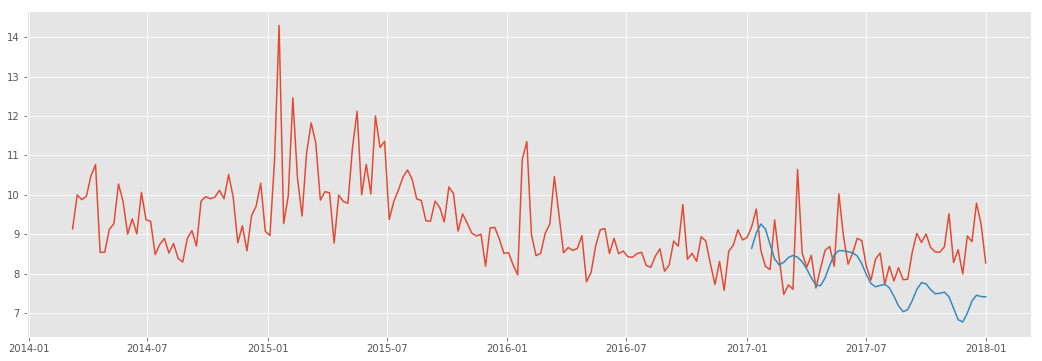

In [80]:
df = pd.DataFrame(endogenous_train) # Formatting a DF how Prophet likes it
df.columns = ['y']
df['ds'] = df.index
m = Prophet(weekly_seasonality=True, daily_seasonality=True)
m.fit(df)

future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)

forecast.index = pd.date_range(start=df.index[0], periods=len(forecast), freq='W')

plt.figure(figsize=(18,6))
plt.plot(weekly_average_response_time[-200:])
plt.plot(forecast['yhat'][-52:])
plt.show()

In [81]:
response_time_mean = np.zeros((len(weekly_average_response_time),1))
response_time_mean.fill(np.mean(weekly_average_response_time[:-52]))

response_time_mean = pd.DataFrame(response_time_mean, 
                                      index=weekly_average_response_time.index)

baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)

baseline_rmse = np.sqrt(baseline_mse)
print('The MSE when guessing the mean is {}'.format(baseline_mse))
print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

The MSE when guessing the mean is 1.1930240270839332
The RMSE when guessing the mean is 1.0922563925580537


In [82]:
mse = ((forecast['yhat'][-52:] - endogenous_test)**2).mean()
rmse = np.sqrt(mse)
print('The MSE for this model is {}'.format(mse))
print('The RMSE for this model is {} \n'.format(rmse))

print(f'''This model does {np.round((((baseline_rmse - rmse) / baseline_rmse) * 100), 
                                    decimals=2)}% better than guessing the mean response time!''')

The MSE for this model is 1.065609308654232
The RMSE for this model is 1.0322835408230784 

This model does 5.49% better than guessing the mean response time!


Hmm. Our custom model actually did a lot better on this dependent variable. Maybe it's just that the validation method we're using is flawed; we will have to investigate time series cross-validation, trying to validate at different split points.

## Let's Explore the Data Further!

While we're at it, we might as well poke around with the data we've been trying to forecast. It might seem counterintuitive to include this at the end, but this is mostly trivia below.

Here's a plot of the weeks with the longest average wait times for an ambulance:

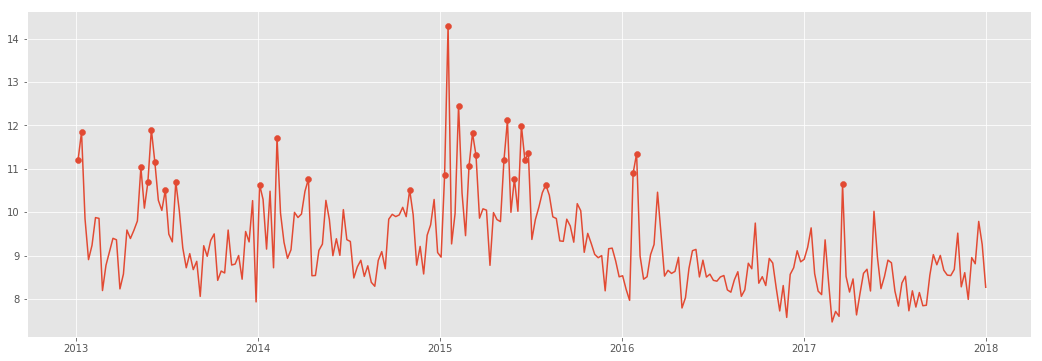

In [83]:
longest_waits = weekly_average_response_time_df.nlargest(28, 'avg_response_time_min').sort_index()['avg_response_time_min']

plt.figure(figsize=(18,6))
plt.scatter(longest_waits.index, longest_waits)
plt.plot(weekly_average_response_time)
plt.show()

In [84]:
weekly_average_response_time_df.nlargest(5, 'avg_response_time_min')

,avg_response_time_min,avg_temp,total_precip,total_snowfall,total_holidays
proper_time,,,,,
2015-01-18,14.297593,30.000000,2.4600,0.001,0.0
2015-02-08,12.459994,27.142857,1.0400,3.301,0.0
2015-05-17,12.116504,68.500000,0.3201,0.000,0.0
2015-06-14,11.998787,76.714286,0.4300,0.000,0.0
2013-06-02,11.907463,73.928571,1.3700,0.000,1.0


What happened during those weeks?

In January 2015, According to the New York Post, "Treacherous black ice created chaos on city streets — including a backlog of hundreds of 911 calls and nearly 60 MTA bus crashes — but rather than address the crisis, City Hall simply blamed the weatherman." https://nypost.com/2015/01/18/black-ice-leads-to-accidents-pileup/

### By Day of the Week

In [85]:
coerced_data['day_of_week'] = coerced_data.index.dayofweek

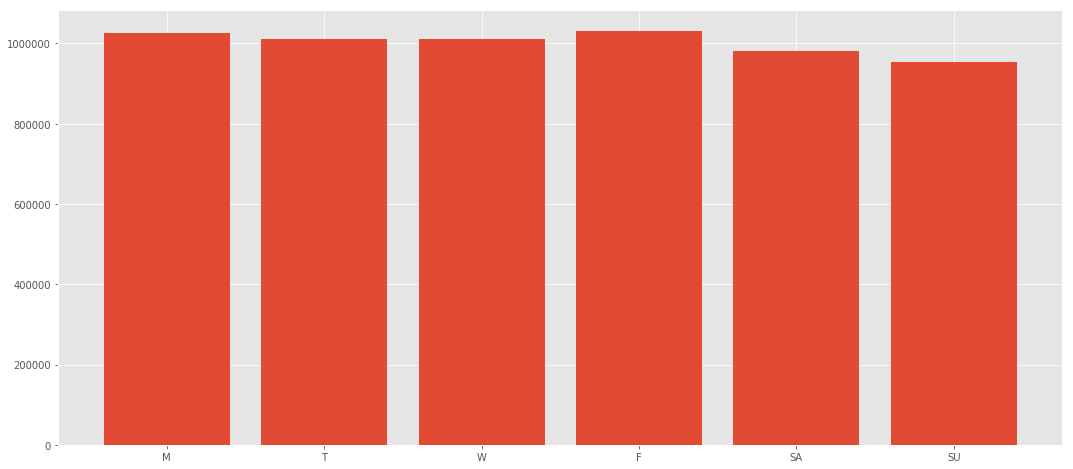

In [86]:
plt.figure(figsize=(18,8))
plt.bar(['M','T','W','T','F','SA','SU'],
    coerced_data.groupby('day_of_week').sum()['count'])
plt.show()

Pretty uniform. Nothing to see here. People don't rage on Sundays, go figure.

### Months of Year

In [87]:
coerced_data['month'] = coerced_data.index.month

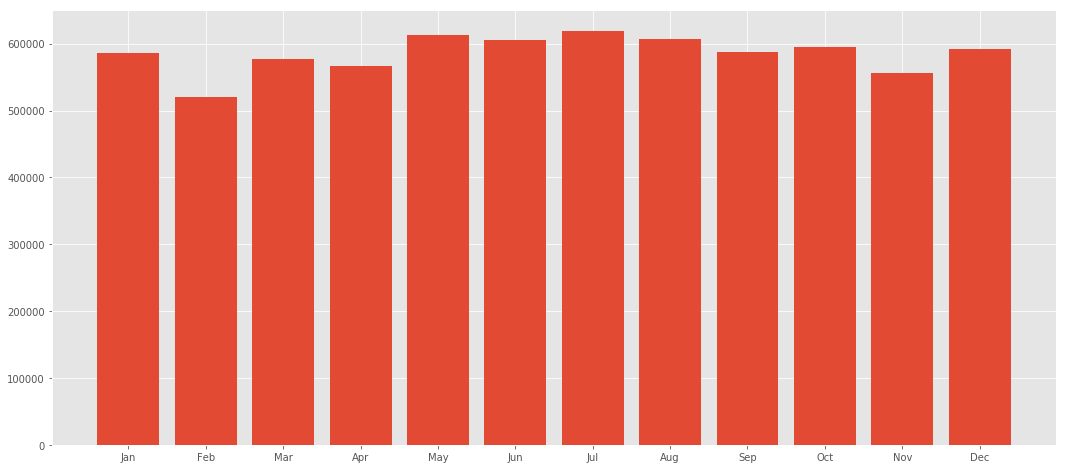

In [88]:
plt.figure(figsize=(18,8))
plt.bar(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    coerced_data.groupby('month').sum()['count'])
plt.show()

I was surprised to see how few calls occurred in February, but then I remembered that February has less days. Again, not much to see here; slightly more calls in the summer months perhaps

### Calls by Type and Borough

In [89]:
call_types = coerced_data.groupby('INITIAL_CALL_TYPE').sum()['count']

In [90]:
call_types = call_types[call_types > 100000]

In [96]:
desc = pd.read_excel('../data/EMS_incident_dispatch_data_description.xlsx', sheet_name='Call Type Descriptions',header=2)


In [97]:
rad = np.full((len(call_types)), .15)

In [98]:
labels = [desc[desc['CALL TYPE'] == i]['CALL TYPE DESCRIPTION'].values[0] for i in call_types.index]

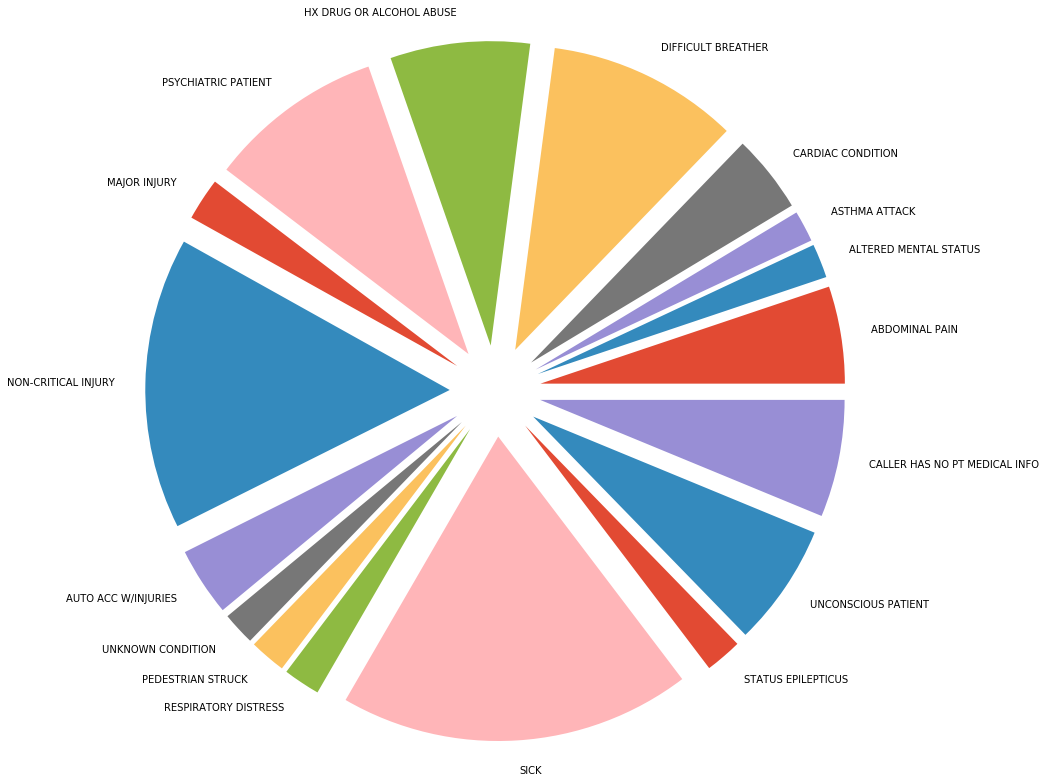

In [99]:
plt.figure(figsize=(14,14))

plt.pie(call_types, 
        explode = rad,
       labels = labels)
plt.show()

There's your general look at the distribution of EMS call types.

In [100]:
def per_cap(grouped):
    return pd.DataFrame.from_dict({'bronx': grouped[0] / 1471160,
            'brooklyn': grouped[1] / 2648771,
            'manhattan': grouped[2] / 1664727,
            'queens': grouped[3] / 2358582,
            'staten': grouped[4] / 479458}, orient='index')

#### Trauma

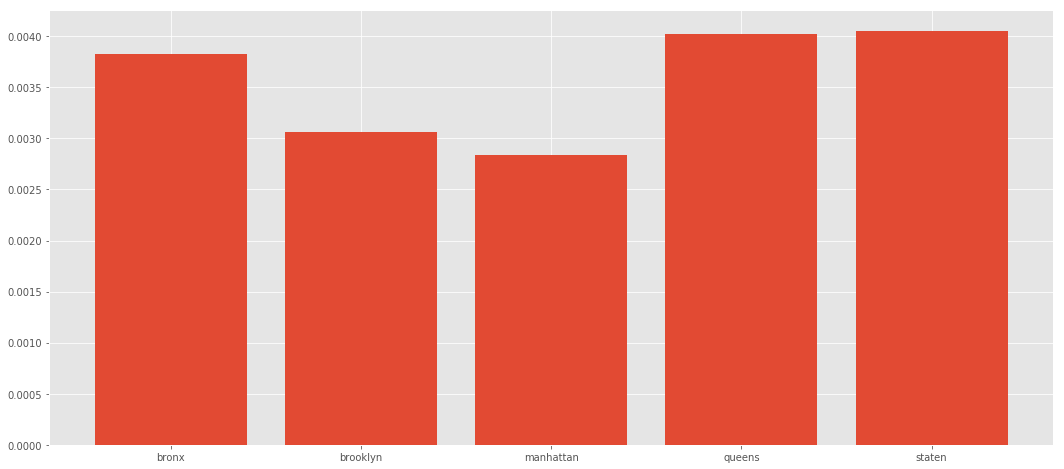

In [101]:
plt.figure(figsize = (18,8))
plt.bar(per_cap(coerced_data[coerced_data['INITIAL_CALL_TYPE'] == 'TRAUMA'].groupby('BOROUGH').sum()['count']).index,
per_cap(coerced_data[coerced_data['INITIAL_CALL_TYPE'] == 'TRAUMA'].groupby('BOROUGH').sum()['count']).iloc[:,0])
plt.show()

#### Burns

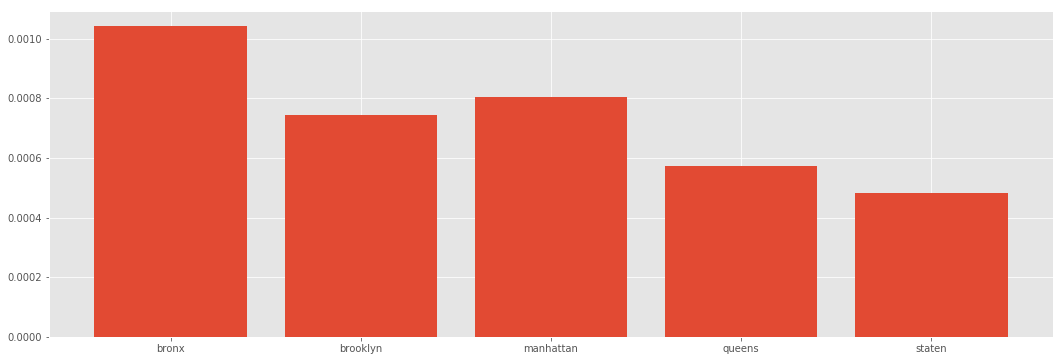

In [102]:
plt.figure(figsize = (18,6))
plt.bar(per_cap(coerced_data[coerced_data['INITIAL_CALL_TYPE'] == 'BURNMA'].groupby('BOROUGH').sum()['count']).index,
per_cap(coerced_data[coerced_data['INITIAL_CALL_TYPE'] == 'BURNMA'].groupby('BOROUGH').sum()['count']).iloc[:,0])
plt.show()

## Let's split it all up by borough!

In [103]:
def avg_time_by_borough(borough_name):
    
    print('The average response time model results for {} are below'.format(borough_name))
    borough_data = coerced_data[coerced_data['BOROUGH'] == borough_name]
    borough_data['count'] = 1

    #regroup data by week 
    borough_call_volume = borough_data['count'].resample('W').sum()
    borough_average_response_time = borough_data['INCIDENT_RESPONSE_SECONDS_QY'].resample('W').mean()

    #modify our avearge response time data to measure time in minutes instead of seconds
    borough_average_response_time = borough_average_response_time / 60

    borough_average_response_time_df = pd.DataFrame(data=borough_average_response_time, index=borough_call_volume.index)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_average_temperature_data, left_index=True, right_index=True)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_sum_precipitation, left_index=True, right_index=True)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_sum_snowfall, left_index=True, right_index=True)
    borough_average_response_time_df = pd.merge(borough_average_response_time_df, weekly_sum_holidays, left_index=True, right_index=True)

    #rename the columns so they are easier to understand and reference
    borough_average_response_time_df.columns = ['avg_response_time_min', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

    endogenous_train = borough_average_response_time[:-52]
    exogenous_train = borough_average_response_time_df.drop(['avg_response_time_min'], axis=1)[:-52]
    endogenous_test = borough_average_response_time[-52:]
    exogenous_test = borough_average_response_time_df.drop(['avg_response_time_min'], axis=1)[-52:]

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                    exog = exogenous_train,
                                    order=(1, 0, 1),
                                    seasonal_order=(0, 1, 1, 52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])

    output.plot_diagnostics(figsize=(15, 8))
    plt.show()

    prediction = output.get_prediction(start = endogenous_test.index[0],
                                        end = endogenous_test.index[-1],
                                        exog = exogenous_test,
                                        dynamic = False)

    pred_conf = prediction.conf_int()

    # Plot the static forecast with confidence intervals.

    ax = borough_average_response_time[-200:].plot(label='observed', figsize=(18, 6))
    prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

    # ax.fill_between(pred_conf.index,
    #                 pred_conf.iloc[:, 0],
    #                 pred_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), 
                     borough_average_response_time[-50:-49].index[0], 
                     '2017-12-31', 
                     alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Avg Response Time')

    plt.legend()
    plt.show()

    response_time_mean = np.zeros((len(borough_average_response_time),1))
    response_time_mean.fill(np.mean(borough_average_response_time[:-52]))
    response_time_mean = pd.DataFrame(response_time_mean, 
                                          index=borough_average_response_time.index)

    baseline_mse = np.mean((response_time_mean[-52:][0] - endogenous_test)**2)
    baseline_rmse = np.sqrt(baseline_mse)
    print('The MSE when guessing the mean is {}'.format(baseline_mse))
    print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

    mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
    rmse = np.sqrt(mse)
    print('The MSE for this model is {}'.format(mse))
    print('The RMSE for this model is {}'.format(rmse))

    print(f'''Our model does {np.round((((baseline_rmse - rmse) / baseline_rmse) * 100), 
                                        decimals=2)}% better than guessing the mean call volume!''')

In [104]:
def volume_by_borough(borough_name):
    print('The call volume model results for {} are below'.format(borough_name))
    
    borough_data = coerced_data[coerced_data['BOROUGH'] == borough_name]
    borough_data['count'] = 1

    #regroup data by week 
    borough_call_volume = borough_data['count'].resample('W').sum()
    borough_average_response_time = borough_data['count'].resample('W').mean()

    #modify our avearge response time data to measure time in minutes instead of seconds
    borough_average_response_time = borough_average_response_time / 60
    
    borough_call_volume_df = pd.DataFrame(data=borough_call_volume, index=borough_call_volume.index)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_average_temperature_data, left_index=True, right_index=True)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_sum_precipitation, left_index=True, right_index=True)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_sum_snowfall, left_index=True, right_index=True)
    borough_call_volume_df = pd.merge(borough_call_volume_df, weekly_sum_holidays, left_index=True, right_index=True)

    #rename the columns so they are easier to understand and reference
    borough_call_volume_df.columns = ['sum of weekly calls', 'avg_temp', 'total_precip', 'total_snowfall', 'total_holidays']

    endogenous_train = borough_call_volume[:-52]
    exogenous_train = borough_call_volume_df.drop(['sum of weekly calls'], axis=1)[:-52]
    endogenous_test = borough_call_volume[-52:]
    exogenous_test = borough_call_volume_df.drop(['sum of weekly calls'], axis=1)[-52:]

    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(endogenous_train,
                                    exog = exogenous_train,
                                    order=(1, 0, 1),
                                    seasonal_order=(0, 1, 1, 52),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()

    print(output.summary().tables[1])

    output.plot_diagnostics(figsize=(15, 8))
    plt.show()

    prediction = output.get_prediction(start = endogenous_test.index[0],
                                        end = endogenous_test.index[-1],
                                        exog = exogenous_test,
                                        dynamic = False)

    pred_conf = prediction.conf_int()

    # Plot the static forecast with confidence intervals.

    ax = borough_call_volume[-200:].plot(label='observed', figsize=(18, 6))
    prediction.predicted_mean.plot(label='Static Forecast', ax=ax)

    # ax.fill_between(pred_conf.index,
    #                 pred_conf.iloc[:, 0],
    #                 pred_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), 
                     borough_call_volume[-50:-49].index[0], 
                     '2017-12-31', 
                     alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Call Volume')

    plt.legend()
    plt.show()

    call_volume_mean = np.zeros((len(borough_call_volume),1))
    call_volume_mean.fill(np.mean(borough_call_volume[:-52]))
    call_volume_mean = pd.DataFrame(call_volume_mean, 
                                          index=borough_call_volume.index)

    baseline_mse = np.mean((call_volume_mean[-52:][0] - endogenous_test)**2)
    baseline_rmse = np.sqrt(baseline_mse)
    print('The MSE when guessing the mean is {}'.format(baseline_mse))
    print('The RMSE when guessing the mean is {}'.format(baseline_rmse))

    mse = ((prediction.predicted_mean - endogenous_test)**2).mean()
    rmse = np.sqrt(mse)
    print('The MSE for this model is {}'.format(mse))
    print('The RMSE for this model is {}'.format(rmse))

    print(f'''Our model does {np.round((((baseline_rmse - rmse) / baseline_rmse) * 100), 
                                        decimals=2)}% better than guessing the mean call volume!''')

**The Bronx:**

The average response time model results for BRONX are below
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
avg_temp          -0.0233         -0        inf      0.000      -0.023      -0.023
total_precip       0.2883         -0       -inf      0.000       0.288       0.288
total_snowfall     0.0797   5.03e-36   1.58e+34      0.000       0.080       0.080
total_holidays     0.9213    1.6e-36   5.76e+35      0.000       0.921       0.921
ar.L1              0.9716   1.59e-35    6.1e+34      0.000       0.972       0.972
ma.L1             -0.6127   2.24e-35  -2.73e+34      0.000      -0.613      -0.613
ma.S.L52       -1.949e+14   1.82e-33  -1.07e+47      0.000   -1.95e+14   -1.95e+14
sigma2          5.812e-13   1.87e-10      0.003      0.998   -3.66e-10    3.67e-10


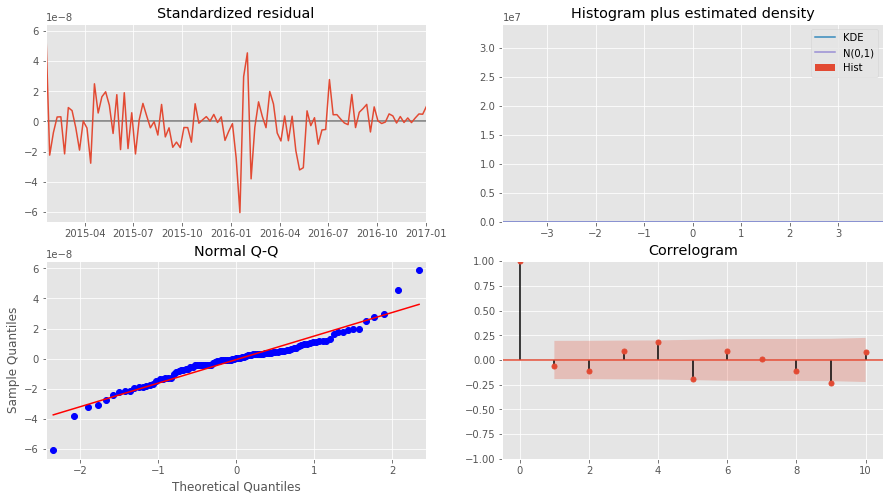

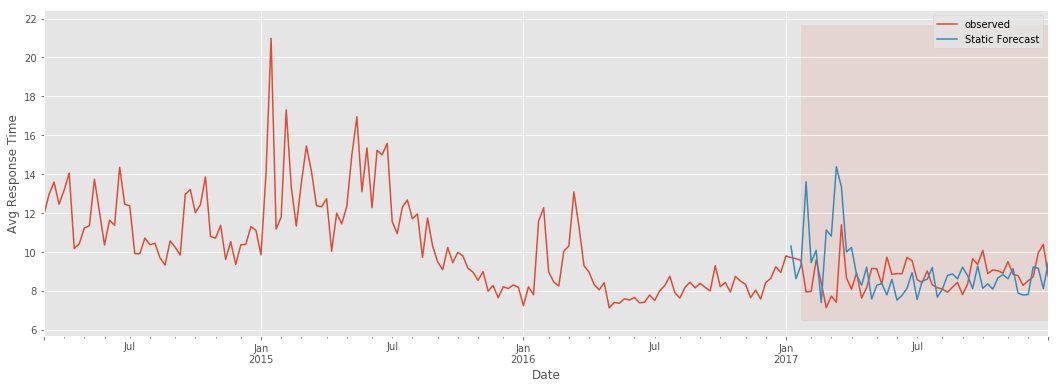

The MSE when guessing the mean is 3.647605569295673
The RMSE when guessing the mean is 1.9098705634926343
The MSE for this model is 3.0423114597272987
The RMSE for this model is 1.7442223080007029
Our model does 8.67% better than guessing the mean call volume!


In [105]:
avg_time_by_borough('BRONX')

In [ ]:
volume_by_borough('BRONX')

**Brooklyn:**

In [ ]:
avg_time_by_borough('BROOKLYN')

In [ ]:
volume_by_borough('BROOKLYN')

**Queens:**

In [ ]:
avg_time_by_borough('QUEENS')

In [ ]:
volume_by_borough('QUEENS')

**Manhattan:**

In [ ]:
avg_time_by_borough('MANHATTAN')

In [ ]:
volume_by_borough('MANHATTAN')

**Staten Island:**

In [ ]:
avg_time_by_borough('RICHMOND / STATEN ISLAND')

In [ ]:
volume_by_borough('RICHMOND / STATEN ISLAND')